In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as ds
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [3]:
mnist_train = ds.MNIST(root = '../', train = True, transform = transforms.ToTensor(), target_transform = None, download = True)
mnist_test = ds.MNIST(root = '../', train = False, transform = transforms.ToTensor(), target_transform = None, download = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 135968758.77it/s]


Extracting ../MNIST/raw/train-images-idx3-ubyte.gz to ../MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 36685552.34it/s]


Extracting ../MNIST/raw/train-labels-idx1-ubyte.gz to ../MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27965141.67it/s]


Extracting ../MNIST/raw/t10k-images-idx3-ubyte.gz to ../MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21722381.72it/s]


Extracting ../MNIST/raw/t10k-labels-idx1-ubyte.gz to ../MNIST/raw



In [4]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

In [8]:
train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle = True, num_workers = 2, drop_last = True)
test_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle = False, num_workers = 2, drop_last = True)

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3),             # [batch_size,1,28,28] -> [batch_size,32,26,26]
            nn.LeakyReLU(),                                                         
            nn.Conv2d(in_channels= 32,out_channels=64,kernel_size = 3),            # [batch_size,32,26,26] -> [batch_size,64,24,24]
            nn.LeakyReLU(),

            nn.Conv2d(in_channels= 64,out_channels=128,kernel_size = 3),            # [batch_size,64,24,24] -> [batch_size,128,22,22]
            nn.LeakyReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=2),                               # [batch_size,128,22,22] -> [batch_size,128,11,11]
            nn.Conv2d(in_channels=128, out_channels= 32, kernel_size=2),          # [batch_size, 128,11,11] -> [batch_size,32,10,10]
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)                                # [batch_size,32,10,10] -> [batch_size,32,5,5]
        )

        # FC layer
        self.fc_layer = nn.Sequential(                                          
            nn.Linear(32 * 5 * 5, 200),                                         # [batch_size, 32*5*5] -> [batch_size,200]
            nn.LeakyReLU(),
            nn.Linear(200,20)                                                   # [batch_size, 200] -> [batch_size, 20]
        )       
        

        
    def forward(self,x):
        out = self.layer(x)                                                 
        out = out.view(batch_size,-1)                                          
                
                                                                        
        out = self.fc_layer(out)
        return out

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model = CNN().to(device)

loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

cuda:0


In [11]:
loss_arr = []

for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y_ = label.to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()

        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

tensor(3.0012, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3485, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1868, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0931, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0438, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1077, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0238, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0979, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0423, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0224, device='cuda:0', grad_fn=<NllLossBackward0>)


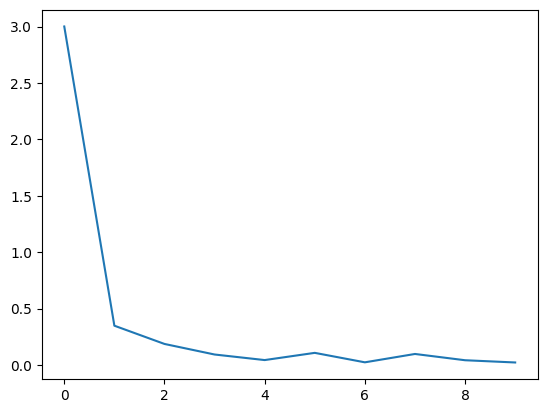

In [12]:
plt.plot(loss_arr)
plt.show()

In [13]:
correct = 0
total = 0

with torch.no_grad():
    for image, label in test_loader:
        
        x = image.to(device)
        y_ = label.to(device)

        output = model.forward(x)

        _, output_index = torch.max(output, 1)

        total += label.size(0)

        correct += (output_index == y_).sum().float()

    print("정확도: {}".format(100* correct / total))

정확도: 99.14029693603516
